<a href="https://colab.research.google.com/github/Nohalyan/Projectppchem/blob/main/Notebook_WSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Water Solubility Prediction Project

This notebook is the core of our Water Solubility Prediction project. This is where we collected, sorted and cleaned the data, as well as selecting, testing and training our prediction models and finaly analyse the results.

This notebook is divided into sections:
1. Modules and Libraries
2. Solubility Data *(optional)*
3. Calculation of RDkit Molecular Descriptors *(optional)*
4. Training and Validation set
5. Select Machine Learning Models
6. Fine-tuning
7. Models for training and test data
8. Saving of the trained model and standard scaler

Sections 2 and 3 are optional, as sorted and cleaned data can be retrieved directly in section 4.1.


## 1 Import Relevant Modules and Libraries

We will start by importing the modules and libraries essential for this project.


In [1]:
# Install all libraries used in this project
!pip install pathlib numpy pandas rdkit matplotlib scikit-learn lightgbm lazypredict tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 21.7 MB/s eta 0:00:00


In [2]:
# Install all modules used in this project
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

import lazypredict
from lazypredict.Supervised import LazyRegressor

from tqdm import tqdm

from google.colab import files

from scipy import stats

# 2. Solubility Data

## 2.1 Let's get the Solubility Data

Firstly, we will acquire solubility data from gashawmg's repository, accessible at https://github.com/gashawmg. Subsequently, we will conduct an exploratory data analysis on the acquired dataset.

In [ ]:
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Solubility.csv

Let's open the file ans confirm that it exist.

In [ ]:
# Create a Path object for the current directory, in our case /content/
current_directory = Path.cwd()
print("Current Directory:", current_directory.resolve())

file_path = current_directory / "Data_Solubility.csv"

# Reading the contents of the file and check that the file exists
if file_path.exists():
    with file_path.open("r") as file:
        content = file.read()
        print(content)
else:
    print("The file does not exist.")


The file use semicicolon as delimiter, so let's open the file and use semicicolon as delimiter:

In [ ]:
# Open a file containing descriptors and yield
data_solubility = pd.read_csv("/content/Data_Solubility.csv", delimiter=';')

Now we will check the data see if it is what we want.

In [ ]:
data_solubility.shape

In [ ]:
data_solubility.head()

## 2.2 Data Cleaning

Now that we've got our data set, we need to clean it up. To do this, we're going to remove non-numericals (NaN) and null values. We'll also sort outliers and make SMILES canonical, so as to duplicate them and obtain a ready-to-use data set.

### 2.2.1 Remove NaN or null values

We will start by removing non-numerical values and values that are null:

In [ ]:
data_solubility.SMILES.isnull().sum()
data_solubility.dropna(inplace=True)
data_solubility.shape

As we can see, the shape is still the same, the data has already been cleaned of non-numerical and null values.

###2.2.2 Remove outliers

Then, we will remove outliers from the data. Using a boxplot, we can easely visualize outliers:


In [ ]:
sn.set_theme()
sn.displot(data=data_solubility, x="logS", binwidth=1)

We will then filter compounds that follow as close as normal distribution. We consider values between -7.5 and 1.7 as following a normal distribution.


In [ ]:
new_data_solubility = data_solubility[data_solubility.logS.apply(lambda x: x > -7.5 and x < 1.7)]

We will generate a histogram to visualize the distribution of the new data.

(9648, 6)

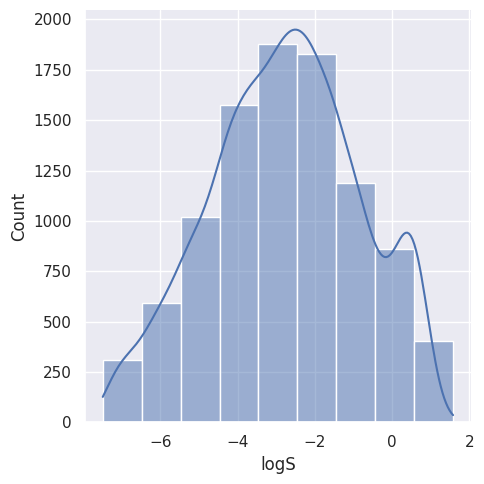

In [ ]:
sn.displot(data=new_data_solubility, x='logS', binwidth=1,kde=True)

### 2.2.3 Remove Duplicates

Then, we will remove duplicate by generating canonical SMILES.

In [ ]:
# Generate a canonical SMILES function
def canonical_SMILES(smiles):
    canon_smls = [Chem.CanonSmiles(smls) for smls in smiles]
    return canon_smls

In [ ]:
# Generate canonical Smiles using the function
canon_smiles = canonical_SMILES(new_data_solubility.SMILES)

# Replace SMILES column with canonical SMILES
new_data_solubility["SMILES"] = canon_smiles

# Create a list for duplicate smiles
duplicate_smiles = new_data_solubility[new_data_solubility['SMILES'].duplicated()]['SMILES'].values
len(duplicate_smiles)

6

Upon analysis,we found out that there are six duplicate entries.

These duplicates will be filtered out and the dataset will be sorted for improved readability.

In [ ]:
new_data_solubility[new_data_solubility['SMILES'].isin(duplicate_smiles)].sort_values(by=['SMILES'])

We removed rows containing duplicate SMILES, retaining the first occurrence of each structure.

In [ ]:
data_solubility_cleaned = new_data_solubility.drop_duplicates(subset=['SMILES'], keep='first')
data_solubility_cleaned.shape
data_solubility_cleaned.head()

### 2.2.4 Filter training data
With the dataset in hand, our next step involves assembling a test set comprising 100 drug-like compounds. These compounds were sourced from https://github.com/PatWalters/solubility.

Starting to import these datas and do a basic check of them.

In [ ]:
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Drug_Like_Solubility.csv

--2024-05-15 08:04:32--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Drug_Like_Solubility.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5557 (5.4K) [text/plain]
Saving to: ‘Data_Drug_Like_Solubility.csv’

Data_Drug_Like_Solu 100%[===================>]   5.43K  --.-KB/s    in 0s      

2024-05-15 08:04:32 (33.6 MB/s) - ‘Data_Drug_Like_Solubility.csv’ saved [5557/5557]



In [ ]:
# Create a Path object for the current directory, in our case /content/
current_directory_dl = Path.cwd()
print("Current Directory:", current_directory.resolve())

file_path_dl = current_directory / "Data_Drug_Like_Solubility.csv"

# Reading the contents of the file and check that the file exists
if file_path.exists():
    with file_path.open("r") as file:
        content = file.read()
#        print(content)
else:
    print("The file does not exist.")

Current Directory: /content


In [ ]:
data_dl = pd.read_csv("/content/Data_Drug_Like_Solubility.csv", delimiter=';')
data_dl.shape

In [ ]:
data_dl.head()

In [ ]:
# Generate canonical Smiles
canon_smiles = canonical_SMILES(data_dl.SMILES)

# Replace SMILES column wit Canonical SMILES
data_dl["SMILES"] = canon_smiles

# Create a list for duplicate smiles
duplicate_data_dl_smiles = data_dl[data_dl['SMILES'].duplicated()]['SMILES'].values
len(duplicate_data_dl_smiles)

0

Now we need to check that there are no duplicates between the data set and the test data set.

In [ ]:
# Molecules used in training and test of the model
data_dl_SMILES = data_dl.SMILES.values

# Filter molecules that are not present in the test set
data_cleaned_final = data_solubility_cleaned[~data_solubility_cleaned['SMILES'].isin(data_dl_SMILES)]
print(f'Compounds present in training set:{len(data_solubility_cleaned) - len(data_cleaned_final)}')
data_cleaned_final.shape

Compounds present in training set:3


(9639, 6)

In [ ]:
# Save the dataframe to a CSV file
data_cleaned_final.to_csv('Data_Cleaned_Final.csv', index=False)

In [ ]:
data_dl= data_dl[data_dl['LogS exp (mol/L)'].apply(lambda x: x > -7.5 and x < 1.7)]
data_dl

# 3. Calculation of RDkit Molecular Descriptors

Calculation of RDkit Molecular Descriptors, which are molecular features for the data set and the test data set.

In [ ]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0]
                                    for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in tqdm(mols):
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(data_cleaned_final['SMILES'])

In [ ]:
df_descriptors = pd.DataFrame(Mol_descriptors, columns=desc_names)
df_descriptors.head()

Calculate molecular descriptors for the test data.

In [ ]:
Mol_descriptors_test , desc_names_test = RDkit_descriptors(data_dl["SMILES"])
data_dl_descriptors = pd.DataFrame(Mol_descriptors_test,columns=desc_names_test)

Save the datas in .csv files.

In [ ]:
df_descriptors.to_csv('Data_Solubility_descriptor.csv', index=False)
data_dl_descriptors.to_csv('Data_Solubility_Drug_Like_descriptor.csv', index=False)

# 4. Training and Validation set

In this part, we will separate the data from the data set into 2 sets: the training set to train the model and the validation set to provide an evaluation of the model on the training dataset to adjust the hyperparameters.

If you have run sections 2. and 3., you can skip to section 4.2, otherwise you must run section 4.1.

##4.1 Acquisition of Sorted, Cleaned Data Sets and RDkit Molecular Descriptors

Import cleaned and sorted data fot the training and test sets.

In [3]:
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Cleaned_Final.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Solubility_descriptor.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Drug_Like_Solubility.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Solubility_Drug_Like_descriptor.csv

--2024-05-16 12:25:20--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Cleaned_Final.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 929243 (907K) [text/plain]
Saving to: ‘Data_Cleaned_Final.csv’

Data_Cleaned_Final. 100%[===================>] 907.46K  5.52MB/s    in 0.2s    

2024-05-16 12:25:21 (5.52 MB/s) - ‘Data_Cleaned_Final.csv’ saved [929243/929243]

--2024-05-16 12:25:21--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_Solubility_descriptor.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting resp

Check if the files are correctly import.

In [4]:
current_directory = Path.cwd()
print("Current Directory:", current_directory.resolve())

file_path = current_directory / "Data_Solubility_Drug_Like_descriptor.csv"

if file_path.exists():
    with file_path.open("r") as file:
        content = file.read()
        print("The file does exist")
else:
    print("The file does not exist.")


Current Directory: /content
The file does exist


Define the differents sets of data.

In [5]:
data_dl = pd.read_csv("/content/Data_Drug_Like_Solubility.csv", delimiter=';')
data_dl= data_dl[data_dl['LogS exp (mol/L)'].apply(lambda x: x > -7.5 and x < 1.7)]
df_descriptors = pd.read_csv("/content/Data_Solubility_descriptor.csv", delimiter=';')
data_cleaned_final = pd.read_csv("/content/Data_Cleaned_Final.csv", delimiter=',')
data_dl_descriptors = pd.read_csv("/content/Data_Solubility_Drug_Like_descriptor.csv", delimiter=',')

## 4.2  Split the chemicals for training and validation set

Define training and validation set and standardize them.

In [6]:
x_train, x_valid, y_train, y_valid = train_test_split(df_descriptors, data_cleaned_final.logS, test_size=0.1,random_state=42)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

#5. Select Machine Learning Models

Let's identify the optimal machine learning models for our water solubility predisction. To accomplish this, we will utilize the "lazypredict" library, specifically leveraging the "LazyRegressor" function to evaluate a selection of 42 machine learning models.

In [ ]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled, x_valid_scaled, y_train, y_valid)

Check the best prediction models thanks to LazyRegressor.

In [ ]:
prediction_tests[:5]

# 6. Fine-tuning

We decided to use the top 3 models, starting from the fatest to the slowest.

## 6.1 LGBMRegressor

We decided to take the LGBMRegressor model because the results generated by this model are comparable to the ExtraTreesRegressor model, but takes a lot less time than the ExtraTreesRegressor model.Let's performs a grid search using GridSearchCV from scikit-learn to find the best hyperparameters for a LightGBM regressor:

In [ ]:
params = {'max_depth' : list(range(20, 30, 1)),
          'n_estimators' : list(range(1278, 1280, 1)) ,
          'learning_rate': list(np.arange(0.04, 0.05, 0.01))}

grid_search = GridSearchCV(LGBMRegressor(random_state = 42),
                            param_grid=params, cv=5, verbose=1)

grid_search.fit(x_train, y_train)

print("Optimized parameters for a LightGBM regressor can be: ", grid_search.best_params_)

We obtained:
* learning_rate: 0.01
* max_depth: 26
* n_estmitors: 901

Let's optimize again with new ranges for max_depth, n_estmitors and learning_rate to obtain even better parameters:


In [ ]:
params_bst = {"max_depth" : list(range(20, 36, 4)),
              "n_estimators" : list(range(850, 1200, 50)),
              "learning_rate" : list(np.arange(0.01, 0.05, 0.01))}

grid_search_bst = GridSearchCV(LGBMRegressor(random_state = 42),
                                  param_grid=params_bst, cv=3, verbose=1)

grid_search_bst.fit(x_train, y_train)
print("The best parameters are: ", grid_search_bst.best_params_)

We obtained:
* learning_rate: 0.04
* max_depth: 24
* n_estmitors: 1151

These are the parameters we will use for our standard LGBMRegressor model.

We also wanted to see if by making new runs and trying to optimize these three hyperparameters even further, we could get an even better model. We therefore made a total of 6 runs (compared with the 2 runs for standard models) for this model and obtained these parameters:
* learning_rate: 0.04
* max_depth: 21
* n_estmitors: 1279

These are the parameters we will use for our studious LGBMRegressor model.

##6.2 XGB Regressor
In order to compare our results obtained for the first model, we have chosen XGB Regressor as the second model for the reasons presented above.

The following code performs hyperparameter optimisation for the XGBoost regression model using grid search with cross-validation.

1. We splited the training data associated with their target variable (i.e. logS in our case) into training and validation sets using train_test_split. The size of the validation set is set to 20% of the total data, and a random seed of 42 is used for reproducibility

2. The training and validation features are scaled using StandardScaler, which standardises the features by removing the mean and obtaining a unit variance

3. A grid of hyperparameters to explore is defined, including the max_depths, n_estimators and learning_rates lists, containing different values for each hyperparameter. By initialising the best_score and best_params variables, the best performances obtained during the search are tracked

4. All the combinations of hyperparameters defined in the grid are tested. For each combination, it creates an XGBoost regression model with the current hyperparameters, fits it to the training data and then evaluates its performance on the validation set using the coefficient of determination score (R^2)

5. If the current combination of hyperparameters produces a higher score than the previous score, the best_score and best_params variables change with the new values

6. The optimised values are then displayed at the end of the various tests

In [ ]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

max_depths = list(range(2, 32, 8))
n_estimators = list(range(1, 201, 20))
learning_rates = list(np.arange(0.01, 1.02, 0.25))

best_score = float('-inf')
best_params = {}

for max_depth in max_depths:
    for n_estimator in n_estimators:
        for learning_rate in learning_rates:

            xgb_regressor = XGBRegressor(max_depth=max_depth,
                                         n_estimators=n_estimator,
                                         learning_rate=learning_rate,
                                         random_state=42)

            xgb_regressor.fit(x_train_scaled, y_train)

            score = xgb_regressor.score(x_val_scaled, y_val)

            if score > best_score:
                best_score = score
                best_params = {'max_depth': max_depth, 'n_estimators': n_estimator, 'learning_rate': learning_rate}

print("Optimized parameters for an XGBoost regressor can be:", best_params)

We obtained for this first run:
- max_depth: 2
- n_estimators: 181
- learning_rate: 0.26

In [ ]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

max_depths = list(range(2, 6, 1))
n_estimators = list(range(100, 700, 50))
learning_rates = list(np.arange(0.05, 0.30, 0.05))

best_score = float('-inf')
best_params = {}

for max_depth in max_depths:
    for n_estimator in n_estimators:
        for learning_rate in learning_rates:

            xgb_regressor = XGBRegressor(max_depth=max_depth,
                                         n_estimators=n_estimator,
                                         learning_rate=learning_rate,
                                         random_state=42)

            xgb_regressor.fit(x_train_scaled, y_train)

            score = xgb_regressor.score(x_val_scaled, y_val)

            if score > best_score:
                best_score = score
                best_params = {'max_depth': max_depth, 'n_estimators': n_estimator, 'learning_rate': learning_rate}

print("Optimized parameters for an XGBoost regressor can be:", best_params)


We obtained for this second run:

- max_depth: 5
- n_estimators: 500
- learning_rate: 0.1

These are the parameters we will use for our standard LGBMRegressor model.

##6.3 HistGradientBoostingClassifier

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

params = {
    'max_depth': list(range(20, 30, 1)),
    'learning_rate': list(np.arange(0.04, 0.05, 0.01))
}

grid_search = GridSearchCV(
    HistGradientBoostingRegressor(random_state=42),
    param_grid=params,
    cv=5,
    verbose=1
)

grid_search.fit(x_train, y_train)

print("Optimized parameters for a HistGradientBoostingRegressor:")
print(grid_search.best_params_)

We obtained for this first run:
- learning_rate: 0.05

- max_depth: 20

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

params = {
    'max_depth': list(range(1, 21, 2)),
    'learning_rate': list(np.arange(0.04, 0.10, 0.02))
}

grid_search = GridSearchCV(
    HistGradientBoostingRegressor(random_state=42),
    param_grid=params,
    cv=5,
    verbose=1
)

grid_search.fit(x_train, y_train)

print("Optimized parameters for a HistGradientBoostingRegressor:")
print(grid_search.best_params_)

We obtained for the second run:
- learning_rate: 0.07999999999999999

- max_depth: 13

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

params = {
    'max_depth': list(range(11, 15, 1)),
    'learning_rate': list(np.arange(0.06, 0.10, 0.005))
}

grid_search = GridSearchCV(
    HistGradientBoostingRegressor(random_state=42),
    param_grid=params,
    cv=5,
    verbose=1
)

grid_search.fit(x_train, y_train)

print("Optimized parameters for a HistGradientBoostingRegressor:")
print(grid_search.best_params_)

Finally, we obtained for the second run:

- learning_rate: 0.095

- max_depth: 14

# 7. Models for training and test data

Let's test our models on the training and test set with the best parameters found with the fine tunning:

## 7.1.1 LGBMRegressor (trained 2 times)

In [7]:
model = LGBMRegressor(n_estimators = 1151,
                      max_depth = 24,
                      learning_rate = 0.04,
                      random_state= 42)

model.fit(x_train_scaled,y_train)
y_preds = model.predict(x_valid_scaled)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20903
[LightGBM] [Info] Number of data points in the train set: 8594, number of used features: 195
[LightGBM] [Info] Start training from score -2.762630
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Define the parameters for the plots.

In [8]:
def plot_data(actual, predicted, title):

    rmse = np.sqrt(mean_squared_error(actual, predicted))

    R2 =r2_score(actual, predicted)
    plt.figure(figsize=(8,6))

    sn.regplot(x=predicted, y=actual, line_kws={"lw": 2, "ls": "--", "color": "red", "alpha": 0.7})
    plt.title(title, color="red")
    plt.xlabel("Predicted logS(mol/L)", color="blue")
    plt.xlim(-8, 1)
    plt.ylabel("Experimental logS(mol/L)", color="blue")
    plt.grid(alpha=0.3)
    R2_patch = mpatches.Patch(label="R2={:04.2f}".format(R2))
    rmse_patch = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
    plt.legend(handles=[R2_patch, rmse_patch])

Let's plot the predicted logS of the validation set and see if our model works and download them in form of .png for the plot and .csv for the datas.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

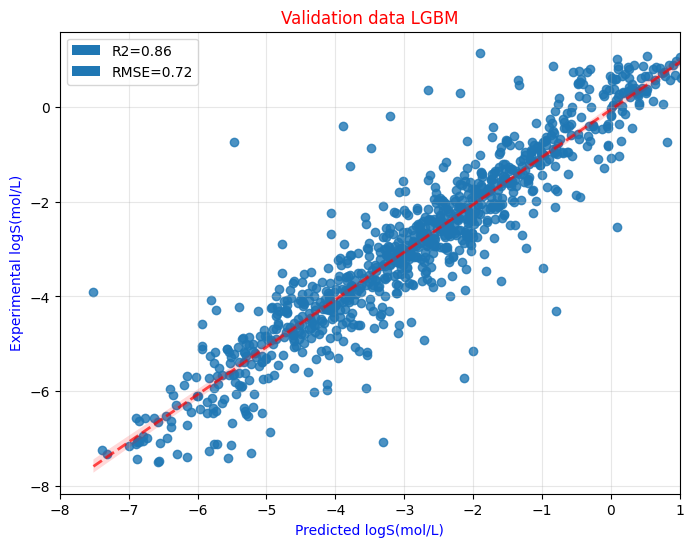

In [9]:
plot_data(y_valid, y_preds, "Validation data LGBM")

plt.savefig('/content/data_LGBM.png')

files.download('/content/data_LGBM.png')

data_to_save = pd.DataFrame({'True Values': y_valid, 'Predicted Values': y_preds})
data_to_save.to_csv('/content/data_LGBM.csv', index=False)

files.download('/content/data_LGBM.csv')

In [10]:
x_scaled_test = scaler.transform(data_dl_descriptors)

y_test_preds = model.predict(x_scaled_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

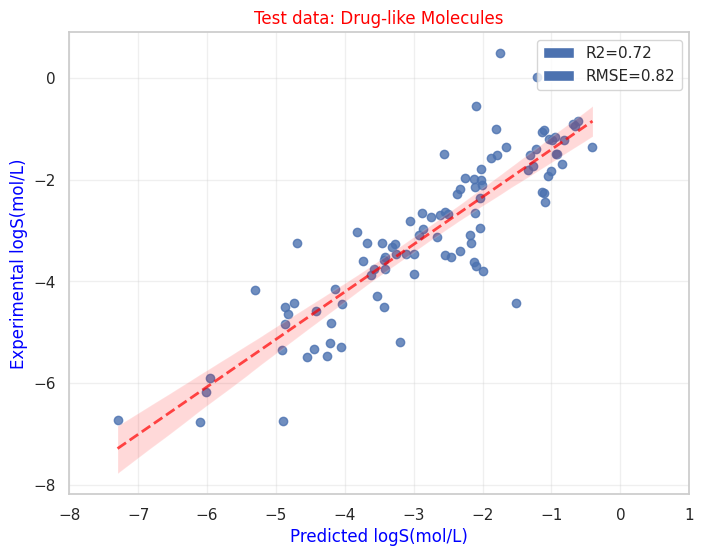

In [ ]:
sn.set_theme(style="whitegrid")
plot_data(data_dl['LogS exp (mol/L)'][:98], y_test_preds,
           "Test data: Drug-like Molecules")

plt.savefig('/content/test_data_LGBM.png')

files.download('/content/test_data_LGBM.png')

data_to_save = pd.DataFrame({'True Values': data_dl["LogS exp (mol/L)"], 'Predicted Values': y_test_preds})
data_to_save.to_csv('/content/test_data_LGBM.csv', index=False)
files.download('/content/test_data_LGBM.csv')


## 7.1.2 LGBMRegressor (trained 6 times)






Here we follow the same steps used for LGBM

In [11]:
model_LGMB6 = LGBMRegressor(n_estimators = 1279,
                      max_depth = 21,
                      learning_rate = 0.04,
                      random_state= 42)

model_LGMB6.fit(x_train_scaled,y_train)
y_preds_LGMB6 = model_LGMB6.predict(x_valid_scaled)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20903
[LightGBM] [Info] Number of data points in the train set: 8594, number of used features: 195
[LightGBM] [Info] Start training from score -2.762630
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [ ]:
def plot_data_LGMB6(actual, predicted, title):

    rmse = np.sqrt(mean_squared_error(actual, predicted))

    R2 =r2_score(actual, predicted)
    plt.figure(figsize=(8,6))

    sn.regplot(x=predicted , y=actual,line_kws={"lw":2,
                                                "ls":"--",
                                                "color":"red",
                                                "alpha":0.7})
    plt.title(title, color="red")
    plt.xlabel("Predicted logS(mol/L)",
               color="blue")
    plt.xlim(-8,1)
    plt.ylabel("Experimental logS(mol/L)",
               color ="blue")

    plt.grid(alpha=0.3)
    R2_patch = mpatches.Patch(label="R2={:04.2f}".format(R2))
    rmse_patch = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
    plt.legend(handles=[R2_patch, rmse_patch])

Let's plot the predicted logS of the validation set and see if our model works.




In [ ]:
from google.colab import files

sn.set_theme(style="whitegrid")
plot_data_LGMB6(y_valid,y_preds_LGMB6,"Validation data LGBM (6 trainings)")

plt.savefig('/content/data_LGBM_6trainings.png')

files.download('/content/data_LGBM_6trainings.png')

data_to_save_LGMB6 = pd.DataFrame({'True Values': y_valid, 'Predicted Values': y_preds_LGMB6})
data_to_save_LGMB6.to_csv('/content/data_LGBM_6trainings.csv', index=False)
files.download('/content/data_LGBM_6trainings.csv')

NameError: name 'plot_data_LGMB6' is not defined

In [ ]:
def plot_data_LGBM2V6(actual, predicted, title, color=None):
    plt.figure(figsize=(8, 6))
    plt.scatter(predicted, actual, alpha=0.5, color=color)
    plt.title(title)
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.grid(alpha=0.3)
    plt.show()


Let's plot the 2 trained LGBM together for see if we have big ddifferences.

In [ ]:
import seaborn as sn

sn.set_theme(style="whitegrid")

plot_data_LGBM2V6(y_valid, y_preds_LGMB6, title="Validation data LGBM (6 trainings)", color="red")

plot_data_LGBM2V6(y_valid, y_preds, title="Validation data LGBM", color="blue")


NameError: name 'y_preds_LGMB6' is not defined

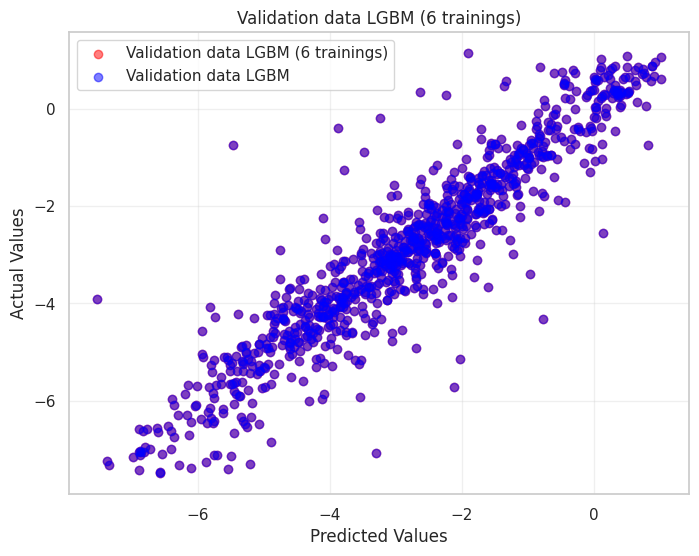

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.set_theme(style="whitegrid")

def plot_data_LGBM2V6(actual1, predicted1, title1, actual2, predicted2, title2):
    plt.figure(figsize=(8, 6))

    plt.scatter(predicted1, actual1, alpha=0.5, color="red", label=title1)

    plt.scatter(predicted2, actual2, alpha=0.5, color="blue", label=title2)

    plt.title("Validation data LGBM (6 trainings)")
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.grid(alpha=0.3)

    plt.legend()

    plt.show()

plot_data_LGBM2V6(y_valid, y_preds_LGMB6, "Validation data LGBM (6 trainings)", y_valid, y_preds, "Validation data LGBM")


In [ ]:
x_scaled_test = scaler.transform(data_dl_descriptors)

y_test_preds_LGMB6 = model_LGMB6.predict(x_scaled_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

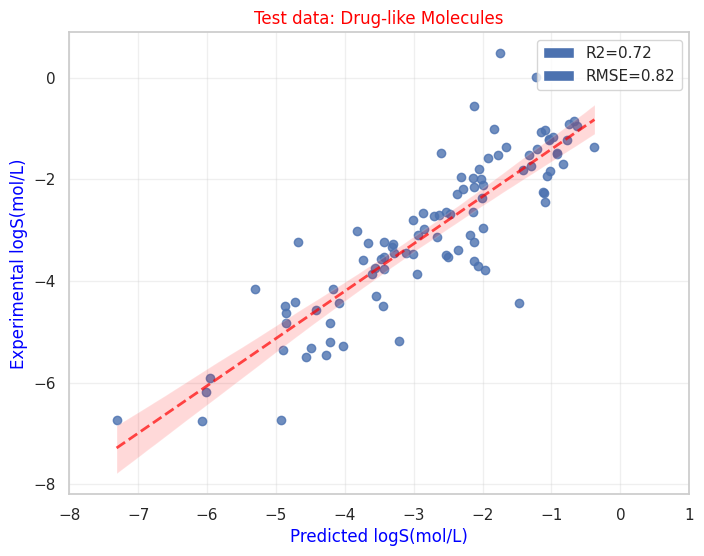

In [ ]:
sn.set_theme(style="whitegrid")
plot_data_LGMB6(data_dl["LogS exp (mol/L)"], y_test_preds_LGMB6,
           "Test data: Drug-like Molecules")

plt.savefig('/content/test_data_LGBM_6trainings.png')

files.download('/content/test_data_LGBM_6trainings.png')

data_to_save_LGMB6 = pd.DataFrame({'True Values': data_dl["LogS exp (mol/L)"], 'Predicted Values': y_test_preds_LGMB6})
data_to_save_LGMB6.to_csv('/content/test_data_LGBM_6trainings.csv', index=False)
files.download('/content/test_data_LGBM_6trainings.csv')

## 7.2 XGB Regressor


In [ ]:
from xgboost import XGBRegressor

model_XGB = XGBRegressor(n_estimators = 500,
                         max_depth = 5,
                         learning_rate = 0.1,
                         random_state = 42)
model_XGB.fit(x_train_scaled,y_train)
y_preds_XGB = model_XGB.predict(x_valid_scaled)

In [ ]:
def plot_data_XGB(actual, predicted, title):

    rmse_XGB = np.sqrt(mean_squared_error(actual, predicted))

    R2_XGB =r2_score(actual, predicted)
    plt.figure(figsize=(8,6))

    sn.regplot(x=predicted , y=actual,line_kws={"lw":2,
                                                "ls":"--",
                                                "color":"red",
                                                "alpha":0.7})
    plt.title(title, color="red")
    plt.xlabel("Predicted logS(mol/L)",
               color="blue")
    plt.xlim(-8,1)
    plt.ylabel("Experimental logS(mol/L)",
               color ="blue")


    plt.grid(alpha=0.3)
    R2_patch_XGB = mpatches.Patch(label="R2_XGB={:04.2f}".format(R2_XGB))
    rmse_patch_XGB = mpatches.Patch(label="RMSE_XGB={:04.2f}".format(rmse_XGB))
    plt.legend(handles=[R2_patch_XGB, rmse_patch_XGB])


Let's plot the predicted logS of the validation set and see if our model works.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

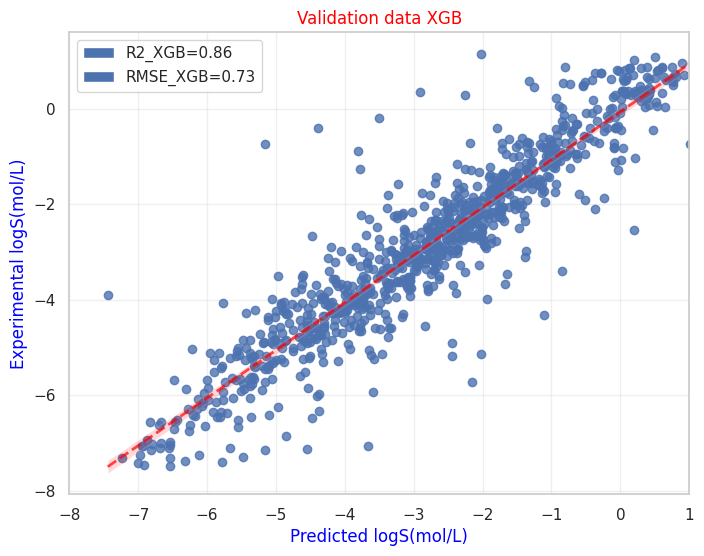

In [ ]:
plot_data_XGB(y_valid,y_preds_XGB,"Validation data XGB")

plt.savefig('/content/data_XGB.png')

files.download('/content/data_XGB.png')

data_to_save_XGB = pd.DataFrame({'True Values': y_valid, 'Predicted Values': y_preds_XGB})
data_to_save_XGB.to_csv('/content/data_XGB.csv', index=False)
files.download('/content/data_XGB.csv')

In [ ]:
x_scaled_test = scaler.transform(data_dl_descriptors)

y_test_preds_XGB = model_XGB.predict(x_scaled_test)

Let's plot the predicted logS of the validation set and see if our model works.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

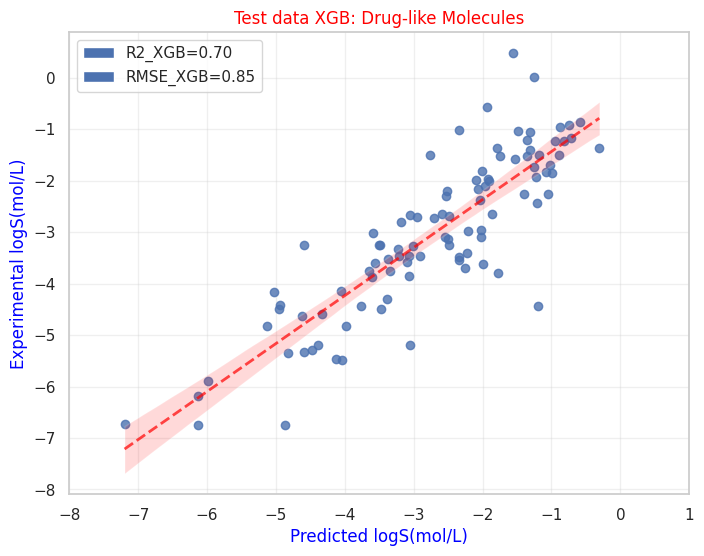

In [ ]:
sn.set_theme(style="whitegrid")
plot_data_XGB(data_dl["LogS exp (mol/L)"], y_test_preds_XGB,
           "Test data XGB: Drug-like Molecules")

plt.savefig('/content/test_data_XGB.png')

files.download('/content/test_data_XGB.png')

data_to_save_test_XGB = pd.DataFrame({'True Values': data_dl["LogS exp (mol/L)"], 'Predicted Values': y_test_preds_XGB})
data_to_save_test_XGB.to_csv('/content/test_data_XGB.csv', index=False)
files.download('/content/test_data_XGB.csv')

##7.3 HistGradientBoostingClassifier

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

model_HGB = HistGradientBoostingRegressor(max_depth = 14,
                         learning_rate = 0.095,
                         random_state = 42)
model_HGB.fit(x_train_scaled,y_train)
y_preds_HGB = model_HGB.predict(x_valid_scaled)

In [ ]:
def plot_data_HGB(actual, predicted, title):

    rmse_HGB = np.sqrt(mean_squared_error(actual, predicted))


    R2_HGB =r2_score(actual, predicted)
    plt.figure(figsize=(8,6))

    sn.regplot(x=predicted , y=actual,line_kws={"lw":2,
                                                "ls":"--",
                                                "color":"red",
                                                "alpha":0.7})
    plt.title(title, color="red")
    plt.xlabel("Predicted logS(mol/L)",
               color="blue")
    plt.xlim(-8,1)
    plt.ylabel("Experimental logS(mol/L)",
               color ="blue")

    plt.grid(alpha=0.3)
    R2_patch_HGB = mpatches.Patch(label="R2_HGB={:04.2f}".format(R2_HGB))
    rmse_patch_HGB = mpatches.Patch(label="RMSE_HGB={:04.2f}".format(rmse_HGB))
    plt.legend(handles=[R2_patch_HGB, rmse_patch_HGB])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

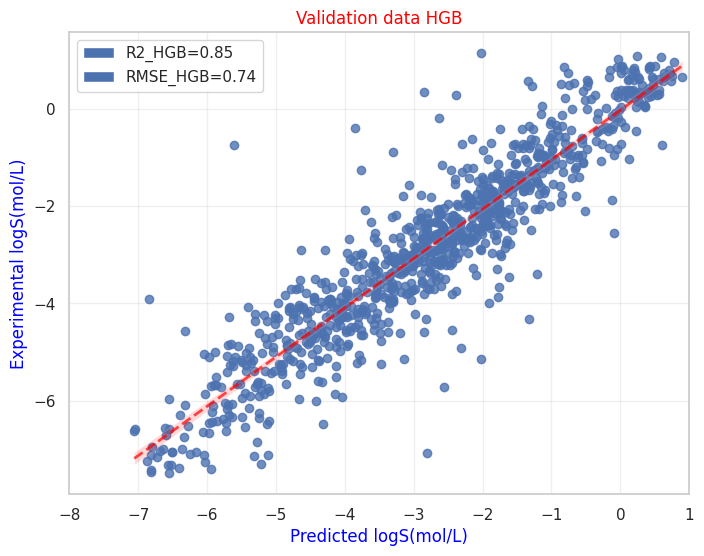

In [ ]:
sn.set_theme(style="whitegrid")
plot_data_HGB(y_valid,y_preds_HGB,"Validation data HGB")

plt.savefig('/content/data_HGB.png')

files.download('/content/data_HGB.png')

data_to_save_HGB = pd.DataFrame({'True Values': y_valid, 'Predicted Values': y_preds_HGB})
data_to_save_HGB.to_csv('/content/data_HGB.csv', index=False)
files.download('/content/data_HGB.csv')

In [ ]:
x_scaled_test = scaler.transform(data_dl_descriptors)

y_test_preds_HGB = model_HGB.predict(x_scaled_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

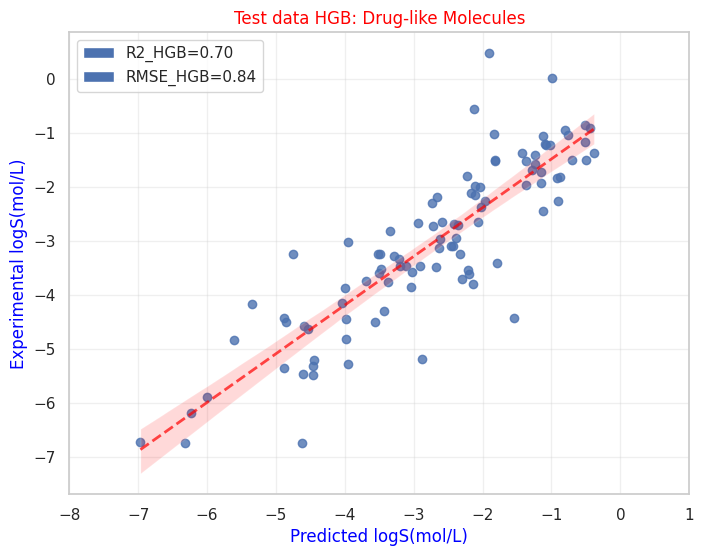

In [ ]:
from google.colab import files

sn.set_theme(style="whitegrid")
plot_data_HGB(data_dl["LogS exp (mol/L)"], y_test_preds_HGB,
           "Test data HGB: Drug-like Molecules")

plt.savefig('/content/test_data_HGB.png')

files.download('/content/test_data_HGB.png')

data_to_save_test_HGB = pd.DataFrame({'True Values': data_dl["LogS exp (mol/L)"], 'Predicted Values': y_test_preds_HGB})
data_to_save_test_HGB.to_csv('/content/test_data_HGB.csv', index=False)
files.download('/content/test_data_HGB.csv')

##7.4 Analysis between the differents Regressors

In this section, the aim is to compare the different approaches to solubility
prediction and to deduce the best approach, based solely on the results and setting aside the time taken to optimise and calculate the regressors.
The regressors LGBM, XGB, HGB and the version of LGBM with more optimised parameters (LGBM 6 trainings) are compared on the following values:
mean error, variance, mean predicted values, MSE and confidence interval.  

Import the datas onbtained by the differents regressors from GitHub :
Let's check with one file

In [ ]:
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/DatasFromRegressors/data_HGB.csv

--2024-05-15 08:04:32--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/Enzo/DatasFromRegressors/data_HGB.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30291 (30K) [text/plain]
Saving to: ‘data_HGB.csv’

data_HGB.csv        100%[===================>]  29.58K  --.-KB/s    in 0.001s  

2024-05-15 08:04:32 (29.0 MB/s) - ‘data_HGB.csv’ saved [30291/30291]



Check if this file is well obtained

In [ ]:
current_directory_data_HGB = Path.cwd()
print("Current Directory:", current_directory.resolve())
file_path_data_HGB = current_directory / "data_HGB.csv"
if file_path_data_HGB.exists():
    with file_path_data_HGB.open("r") as file:
        content = file.read()
else:
    print("The file does not exist.")
data_HGB = pd.read_csv("/content/data_HGB.csv", delimiter=',')
data_HGB.shape

Current Directory: /content


(955, 2)

Import the others files

In [ ]:
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_from_Regressors/data_LGBM.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_from_Regressors/data_LGBM_6trainings.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_from_Regressors/data_XGB.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_from_Regressors/test_data_HGB.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_from_Regressors/test_data_LGBM.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_from_Regressors/test_data_LGBM_6trainings.csv
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data/Data_from_Regressors/test_data_XGB.csv

--2024-05-15 08:04:32--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/Enzo/DatasFromRegressors/data_LGBM.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30265 (30K) [text/plain]
Saving to: ‘data_LGBM.csv’

data_LGBM.csv       100%[===================>]  29.56K  --.-KB/s    in 0s      

2024-05-15 08:04:33 (84.4 MB/s) - ‘data_LGBM.csv’ saved [30265/30265]

--2024-05-15 08:04:33--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/Enzo/DatasFromRegressors/data_LGBM_6trainings.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response...

Associate the differents set of datas with a name

In [ ]:
data_LGBM = pd.read_csv("/content/data_LGBM.csv", delimiter=',')
data_LGBM_6trainings = pd.read_csv("/content/data_LGBM_6trainings.csv", delimiter=',')
data_XGB = pd.read_csv("/content/data_XGB.csv", delimiter=',')
test_data_HGB = pd.read_csv("/content/test_data_HGB.csv", delimiter=',')
test_data_LGBM = pd.read_csv("/content/test_data_LGBM.csv", delimiter=',')
test_data_LGBM_6trainings = pd.read_csv("/content/test_data_LGBM_6trainings.csv", delimiter=',')
test_data_XGB = pd.read_csv("/content/test_data_XGB.csv", delimiter=',')

After set up the datas we will calculates the different analytic values :

mean error, variance, mean predicted values, MSE and confidence interval.

In [ ]:
def confidence_interval(true_values, predicted_values, confidence=0.95):
    errors = true_values - predicted_values
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    n = len(true_values)
    t_score = stats.t.ppf((1 + confidence) / 2, n - 1)
    margin_error = t_score * (std_error / np.sqrt(n))
    lower_bound = mean_error - margin_error
    upper_bound = mean_error + margin_error
    return mean_error, lower_bound, upper_bound

In [ ]:
from scipy import stats

True_values_data_HGB = data_HGB['True Values']
Predicted_values_data_HGB = data_HGB['Predicted Values']

# Calculating confidence interval
mean_error_data_HGB, lower_bound_data_HGB, upper_bound_data_HGB = confidence_interval(True_values_data_HGB, Predicted_values_data_HGB)

# Calculating variance
variance_data_HGB = np.var(True_values_data_HGB - Predicted_values_data_HGB)

# Other descriptive statistics
mean_true_values_data_HGB = np.mean(True_values_data_HGB)
mean_predicted_values_data_HGB = np.mean(Predicted_values_data_HGB)
mse_data_HGB = np.mean((True_values_data_HGB - Predicted_values_data_HGB)**2)

# Displaying the results
print("Mean Error:", mean_error_data_HGB)
print("Confidence Interval (95%):", (lower_bound_data_HGB, upper_bound_data_HGB))
print("Variance:", variance_data_HGB)
print("Mean True Values:", mean_true_values_data_HGB)
print("Mean Predicted Values:", mean_predicted_values_data_HGB)
print("Mean Squared Error (MSE):", mse_data_HGB)


Mean Error: -0.06828024051933804
Confidence Interval (95%): (-0.11525829557863546, -0.021302185460040618)
Variance: 0.5472610983432556
Mean True Values: -2.8421715605434557
Mean Predicted Values: -2.7738913200241173
Mean Squared Error (MSE): 0.5519232895886343


In [ ]:
True_values_data_LGBM= data_LGBM['True Values']
Predicted_values_data_LGBM= data_LGBM['Predicted Values']

# Calculating confidence interval
mean_error_data_LGBM, lower_bound_data_LGBM, upper_bound_data_LGBM= confidence_interval(True_values_data_LGBM, Predicted_values_data_LGBM)

# Calculating variance
variance_data_LGBM= np.var(True_values_data_LGBM- Predicted_values_data_LGBM)

# Other descriptive statistics
mean_true_values_data_LGBM= np.mean(True_values_data_LGBM)
mean_predicted_values_data_LGBM= np.mean(Predicted_values_data_LGBM)
mse_data_LGBM= np.mean((True_values_data_LGBM- Predicted_values_data_LGBM)**2)

# Displaying the results
print("Mean Error:", mean_error_data_LGBM)
print("Confidence Interval (95%):", (lower_bound_data_LGBM, upper_bound_data_LGBM))
print("Variance:", variance_data_LGBM)
print("Mean True Values:", mean_true_values_data_LGBM)
print("Mean Predicted Values:", mean_predicted_values_data_LGBM)
print("Mean Squared Error (MSE):", mse_data_LGBM)


Mean Error: -0.06474577386275801
Confidence Interval (95%): (-0.10997881077925999, -0.019512736946256035)
Variance: 0.5073597451597645
Mean True Values: -2.8421715605434557
Mean Predicted Values: -2.7774257866806975
Mean Squared Error (MSE): 0.5115517603928519


In [ ]:
True_values_data_XGB = data_XGB['True Values']
Predicted_values_data_XGB = data_XGB['Predicted Values']

# Calculating confidence interval
mean_error_data_XGB, lower_bound_data_XGB, upper_bound_data_XGB= confidence_interval(True_values_data_XGB, Predicted_values_data_XGB)

# Calculating variance
variance_data_XGB= np.var(True_values_data_XGB- Predicted_values_data_XGB)

# Other descriptive statistics
mean_true_values_data_XGB= np.mean(True_values_data_XGB)
mean_predicted_values_data_XGB= np.mean(Predicted_values_data_XGB)
mse_data_XGB= np.mean((True_values_data_XGB- Predicted_values_data_XGB)**2)

# Displaying the results
print("Mean Error:", mean_error_data_XGB)
print("Confidence Interval (95%):", (lower_bound_data_XGB, upper_bound_data_XGB))
print("Variance:", variance_data_XGB)
print("Mean True Values:", mean_true_values_data_XGB)
print("Mean Predicted Values:", mean_predicted_values_data_XGB)
print("Mean Squared Error (MSE):", mse_data_XGB)


Mean Error: -0.0634299786885864
Confidence Interval (95%): (-0.10953603902294866, -0.01732391835422413)
Variance: 0.527133407823029
Mean True Values: -2.8421715605434557
Mean Predicted Values: -2.7787415818548684
Mean Squared Error (MSE): 0.5311567700194636


In [ ]:
True_values_data_LGBM_6trainings = data_LGBM_6trainings ['True Values']
Predicted_values_data_LGBM_6trainings = data_LGBM_6trainings ['Predicted Values']

# Calculating confidence interval
mean_error_data_LGBM_6trainings , lower_bound_data_LGBM_6trainings , upper_bound_data_LGBM_6trainings = confidence_interval(True_values_data_LGBM_6trainings , Predicted_values_data_LGBM_6trainings )

# Calculating variance
variance_data_LGBM_6trainings = np.var(True_values_data_LGBM_6trainings - Predicted_values_data_LGBM_6trainings )

# Other descriptive statistics
mean_true_values_data_LGBM_6trainings = np.mean(True_values_data_LGBM_6trainings )
mean_predicted_values_data_LGBM_6trainings = np.mean(Predicted_values_data_LGBM_6trainings )
mse_data_LGBM_6trainings = np.mean((True_values_data_LGBM_6trainings - Predicted_values_data_LGBM_6trainings )**2)

# Displaying the results
print("Mean Error:", mean_error_data_LGBM_6trainings )
print("Confidence Interval (95%):", (lower_bound_data_LGBM_6trainings , upper_bound_data_LGBM_6trainings ))
print("Variance:", variance_data_LGBM_6trainings )
print("Mean True Values:", mean_true_values_data_LGBM_6trainings )
print("Mean Predicted Values:", mean_predicted_values_data_LGBM_6trainings )
print("Mean Squared Error (MSE):", mse_data_LGBM_6trainings )


Mean Error: -0.06418089762641543
Confidence Interval (95%): (-0.10949286864941227, -0.018868926603418594)
Variance: 0.5091320308096099
Mean True Values: -2.8421715605434557
Mean Predicted Values: -2.77799066291704
Mean Squared Error (MSE): 0.5132512184297423


In [ ]:
True_values_test_data_LGBM= test_data_LGBM['True Values']
Predicted_values_test_data_LGBM= test_data_LGBM['Predicted Values']

# Calculating confidence interval
mean_error_test_data_LGBM, lower_bound_test_data_LGBM, upper_bound_test_data_LGBM= confidence_interval(True_values_test_data_LGBM, Predicted_values_test_data_LGBM)

# Calculating variance
variance_test_data_LGBM= np.var(True_values_test_data_LGBM- Predicted_values_test_data_LGBM)

# Other descriptive statistics
mean_true_values_test_data_LGBM= np.mean(True_values_test_data_LGBM)
mean_predicted_values_test_data_LGBM= np.mean(Predicted_values_test_data_LGBM)
mse_test_data_LGBM= np.mean((True_values_test_data_LGBM- Predicted_values_test_data_LGBM)**2)

# Displaying the results
print("Mean Error:", mean_error_test_data_LGBM)
print("Confidence Interval (95%):", (lower_bound_test_data_LGBM, upper_bound_test_data_LGBM))
print("Variance:", variance_test_data_LGBM)
print("Mean True Values:", mean_true_values_test_data_LGBM)
print("Mean Predicted Values:", mean_predicted_values_test_data_LGBM)
print("Mean Squared Error (MSE):", mse_test_data_LGBM)


Mean Error: -0.2900412697090068
Confidence Interval (95%): (-0.443610921305471, -0.13647161811254258)
Variance: 0.5867282336647691
Mean True Values: -3.0263265306122453
Mean Predicted Values: -2.736285260903238
Mean Squared Error (MSE): 0.6708521717991819


In [ ]:
True_values_test_data_XGB= test_data_XGB['True Values']
Predicted_values_test_data_XGB= test_data_XGB['Predicted Values']

# Calculating confidence interval
mean_error_test_data_XGB, lower_bound_test_data_XGB, upper_bound_test_data_XGB= confidence_interval(True_values_test_data_XGB, Predicted_values_test_data_XGB)

# Calculating variance
variance_test_data_XGB= np.var(True_values_test_data_XGB- Predicted_values_test_data_XGB)

# Other descriptive statistics
mean_true_values_test_data_XGB= np.mean(True_values_test_data_XGB)
mean_predicted_values_test_data_XGB= np.mean(Predicted_values_test_data_XGB)
mse_test_data_XGB= np.mean((True_values_test_data_XGB- Predicted_values_test_data_XGB)**2)

# Displaying the results
print("Mean Error:", mean_error_test_data_XGB)
print("Confidence Interval (95%):", (lower_bound_test_data_XGB, upper_bound_test_data_XGB))
print("Variance:", variance_test_data_XGB)
print("Mean True Values:", mean_true_values_test_data_XGB)
print("Mean Predicted Values:", mean_predicted_values_test_data_XGB)
print("Mean Squared Error (MSE):", mse_test_data_XGB)


Mean Error: -0.316946628367347
Confidence Interval (95%): (-0.4760527020573729, -0.1578405546773211)
Variance: 0.6297957223410321
Mean True Values: -3.0263265306122453
Mean Predicted Values: -2.7093799022448977
Mean Squared Error (MSE): 0.7302508875744612


In [ ]:
True_values_test_data_HGB= test_data_HGB['True Values']
Predicted_values_test_data_HGB= test_data_HGB['Predicted Values']

# Calculating confidence interval
mean_error_test_data_HGB, lower_bound_test_data_HGB, upper_bound_test_data_HGB= confidence_interval(True_values_test_data_HGB, Predicted_values_test_data_HGB)

# Calculating variance
variance_test_data_HGB= np.var(True_values_test_data_HGB- Predicted_values_test_data_HGB)

# Other descriptive statistics
mean_true_values_test_data_HGB= np.mean(True_values_test_data_HGB)
mean_predicted_values_test_data_HGB= np.mean(Predicted_values_test_data_HGB)
mse_test_data_HGB= np.mean((True_values_test_data_HGB- Predicted_values_test_data_HGB)**2)

# Displaying the results
print("Mean Error:", mean_error_test_data_HGB)
print("Confidence Interval (95%):", (lower_bound_test_data_HGB, upper_bound_test_data_HGB))
print("Variance:", variance_test_data_HGB)
print("Mean True Values:", mean_true_values_test_data_HGB)
print("Mean Predicted Values:", mean_predicted_values_test_data_HGB)
print("Mean Squared Error (MSE):", mse_test_data_HGB)


Mean Error: -0.3131759955289629
Confidence Interval (95%): (-0.4700870943263685, -0.1562648967315573)
Variance: 0.612538677439905
Mean True Values: -3.0263265306122453
Mean Predicted Values: -2.7131505350832814
Mean Squared Error (MSE): 0.710617881615462


In [ ]:
True_values_test_data_LGBM_6trainings = test_data_LGBM_6trainings ['True Values']
Predicted_values_test_data_LGBM_6trainings = test_data_LGBM_6trainings ['Predicted Values']

# Calculating confidence interval
mean_error_test_data_LGBM_6trainings , lower_bound_test_data_LGBM_6trainings , upper_bound_test_data_LGBM_6trainings = confidence_interval(True_values_test_data_LGBM_6trainings , Predicted_values_test_data_LGBM_6trainings )

# Calculating variance
variance_test_data_LGBM_6trainings = np.var(True_values_test_data_LGBM_6trainings - Predicted_values_test_data_LGBM_6trainings )

# Other descriptive statistics
mean_true_values_test_data_LGBM_6trainings = np.mean(True_values_test_data_LGBM_6trainings )
mean_predicted_values_test_data_LGBM_6trainings = np.mean(Predicted_values_test_data_LGBM_6trainings )
mse_test_data_LGBM_6trainings = np.mean((True_values_test_data_LGBM_6trainings - Predicted_values_test_data_LGBM_6trainings )**2)

# Displaying the results
print("Mean Error:", mean_error_test_data_LGBM_6trainings )
print("Confidence Interval (95%):", (lower_bound_test_data_LGBM_6trainings , upper_bound_test_data_LGBM_6trainings ))
print("Variance:", variance_test_data_LGBM_6trainings )
print("Mean True Values:", mean_true_values_test_data_LGBM_6trainings )
print("Mean Predicted Values:", mean_predicted_values_test_data_LGBM_6trainings )
print("Mean Squared Error (MSE):", mse_test_data_LGBM_6trainings )



Mean Error: -0.2871739537037013
Confidence Interval (95%): (-0.4414627628882198, -0.13288514451918282)
Variance: 0.5922363277517092
Mean True Values: -3.0263265306122453
Mean Predicted Values: -2.7391525769085434
Mean Squared Error (MSE): 0.6747052074375248


In [ ]:
Training_Mean_Error = [mean_error_data_LGBM,mean_error_data_XGB,mean_error_data_HGB,mean_error_data_LGBM_6trainings]
Training_Confidence_Interval =[(lower_bound_data_LGBM , upper_bound_data_LGBM ),(lower_bound_data_XGB , upper_bound_data_XGB ),(lower_bound_data_HGB , upper_bound_data_HGB ),(lower_bound_data_LGBM_6trainings , upper_bound_data_LGBM_6trainings )]
Training_Variance =[variance_data_LGBM, variance_data_XGB, variance_data_HGB, variance_data_LGBM_6trainings]
Training_Mean_True_Values =[mean_true_values_data_LGBM, mean_true_values_data_XGB, mean_true_values_data_HGB, mean_true_values_data_LGBM_6trainings]
Training_Mean_Predicted_Values =[mean_predicted_values_data_LGBM, mean_predicted_values_data_XGB, mean_predicted_values_data_HGB, mean_predicted_values_data_LGBM_6trainings]
Training_MSE = [mse_test_data_LGBM, mse_test_data_XGB ,mse_test_data_HGB, mse_test_data_LGBM_6trainings]

Testing_Mean_Error =[mean_error_test_data_LGBM, mean_error_test_data_XGB ,mean_error_test_data_HGB,mean_error_test_data_LGBM_6trainings]
Testing_Confidence_Interval =[(lower_bound_test_data_LGBM , upper_bound_test_data_LGBM ),(lower_bound_test_data_XGB , upper_bound_test_data_XGB ),(lower_bound_test_data_HGB , upper_bound_test_data_HGB ),(lower_bound_test_data_LGBM_6trainings , upper_bound_test_data_LGBM_6trainings )]
Testing_Variance = [variance_test_data_LGBM,variance_test_data_XGB, variance_test_data_HGB,variance_test_data_LGBM_6trainings]
Testing_Mean_True_Values =[mean_true_values_test_data_LGBM, mean_true_values_test_data_XGB,mean_true_values_test_data_HGB,mean_true_values_test_data_LGBM_6trainings]
Testing_Mean_Predicted_Values =[mean_predicted_values_test_data_LGBM, mean_predicted_values_test_data_XGB,mean_predicted_values_test_data_HGB,mean_predicted_values_test_data_LGBM_6trainings]
Testing_MSE =[mse_test_data_LGBM, mse_test_data_XGB, mse_test_data_HGB,mse_test_data_LGBM_6trainings]

Let's plot the different values in graph for a better view of the results

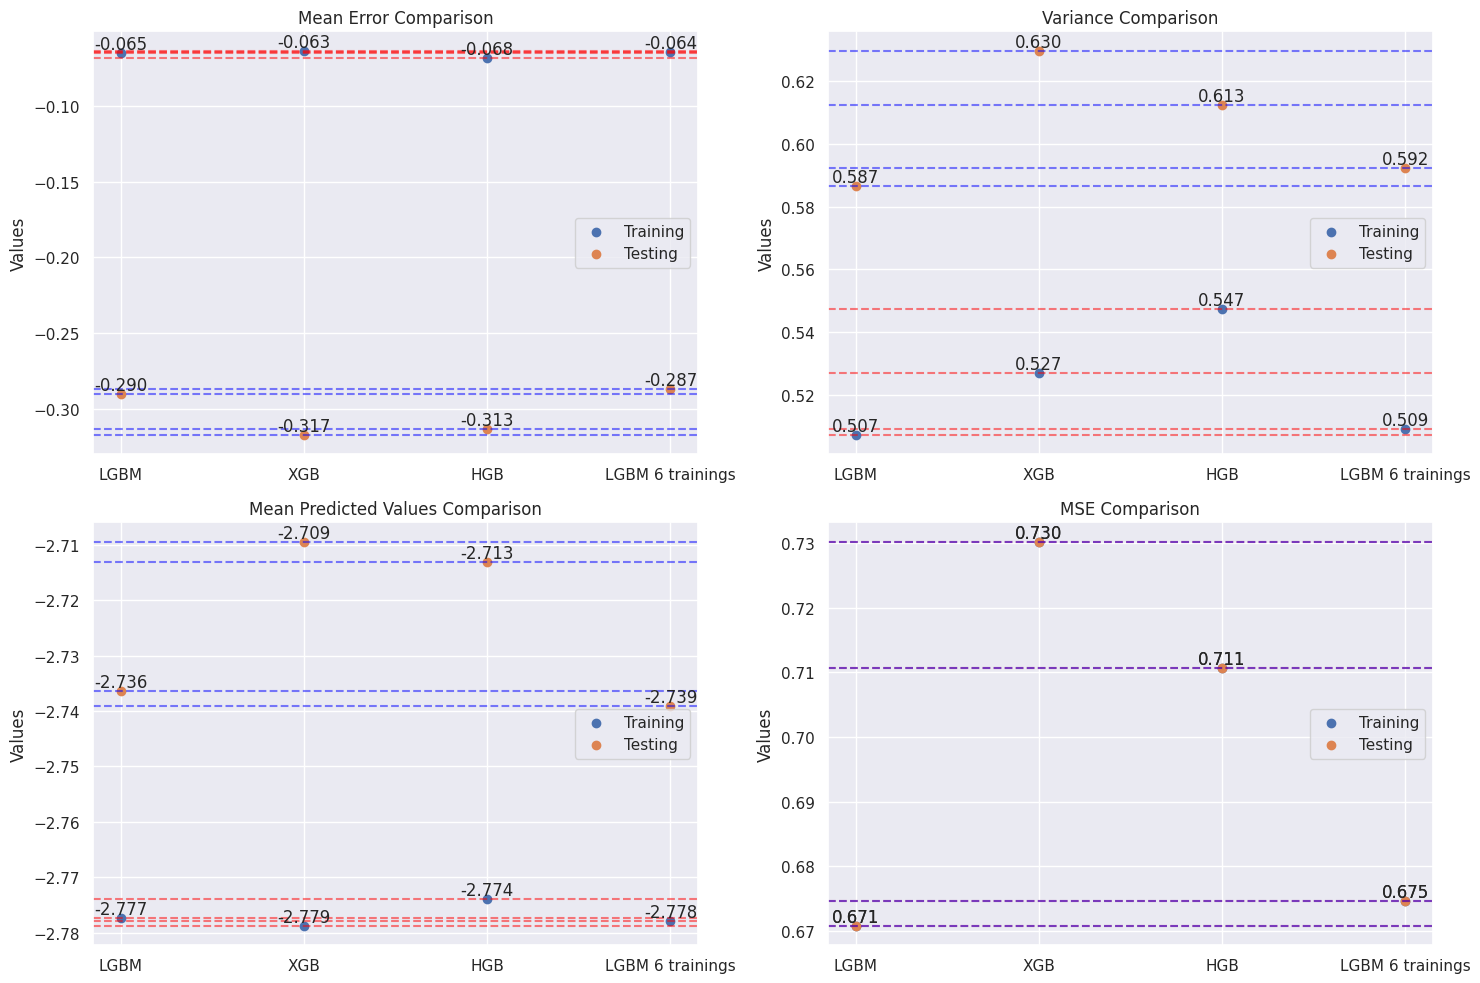

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels for each model
models = ['LGBM', 'XGB', 'HGB', 'LGBM 6 trainings']

# Function to create comparison scatter plots
def plot_comparison_scatter(data1, data2, title, ax):
    ax.scatter(models, data1, label='Training')
    ax.scatter(models, data2, label='Testing')
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.legend()

    # Add dashed horizontal lines for each point
    for i, model in enumerate(models):
        ax.axhline(data1[i], linestyle='--', color='red', alpha=0.5)  # Horizontal line for training data point
        ax.axhline(data2[i], linestyle='--', color='blue', alpha=0.5)  # Horizontal line for testing data point

        # Add the value next to each point
        ax.text(i, data1[i], f'{data1[i]:.3f}', ha='center', va='bottom')
        ax.text(i, data2[i], f'{data2[i]:.3f}', ha='center', va='bottom')

# Create a figure and axes for subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting for Mean Error
plot_comparison_scatter(Training_Mean_Error, Testing_Mean_Error, 'Mean Error Comparison', axs[0, 0])

# Plotting for Variance
plot_comparison_scatter(Training_Variance, Testing_Variance, 'Variance Comparison', axs[0, 1])

# Plotting for Mean Predicted Values
plot_comparison_scatter(Training_Mean_Predicted_Values, Testing_Mean_Predicted_Values, 'Mean Predicted Values Comparison', axs[1, 0])

# Plotting for MSE
plot_comparison_scatter(Training_MSE, Testing_MSE, 'MSE Comparison', axs[1, 1])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


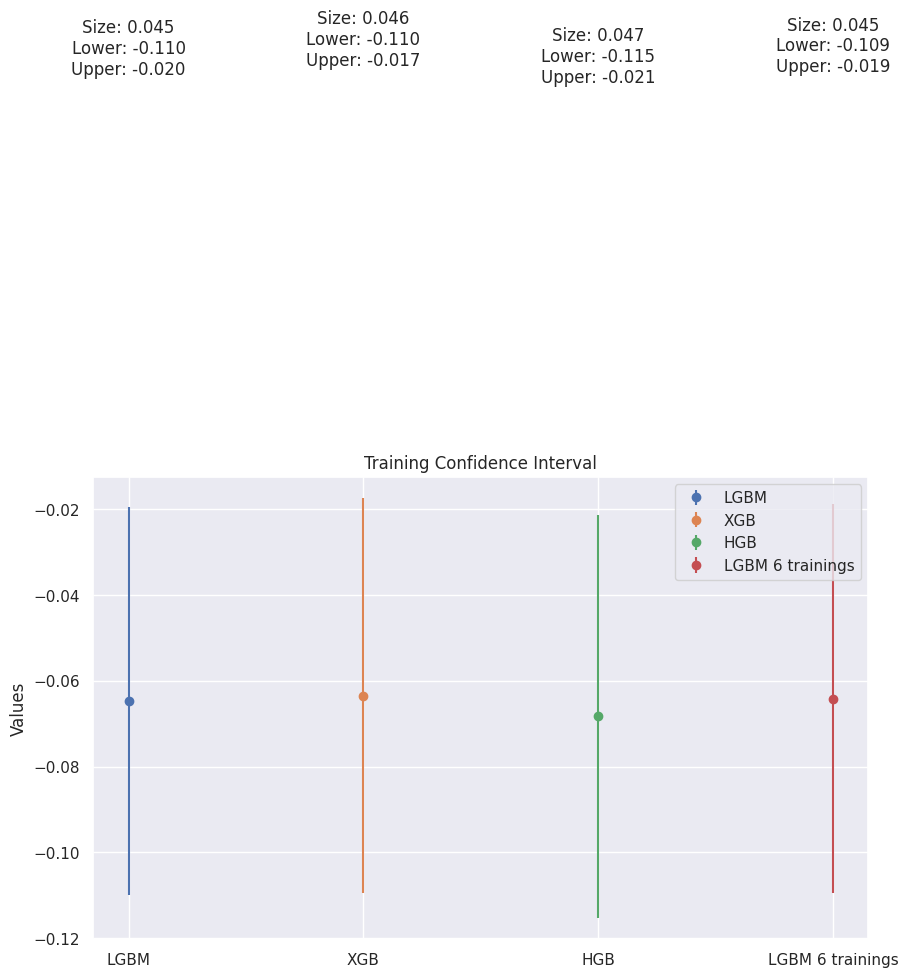

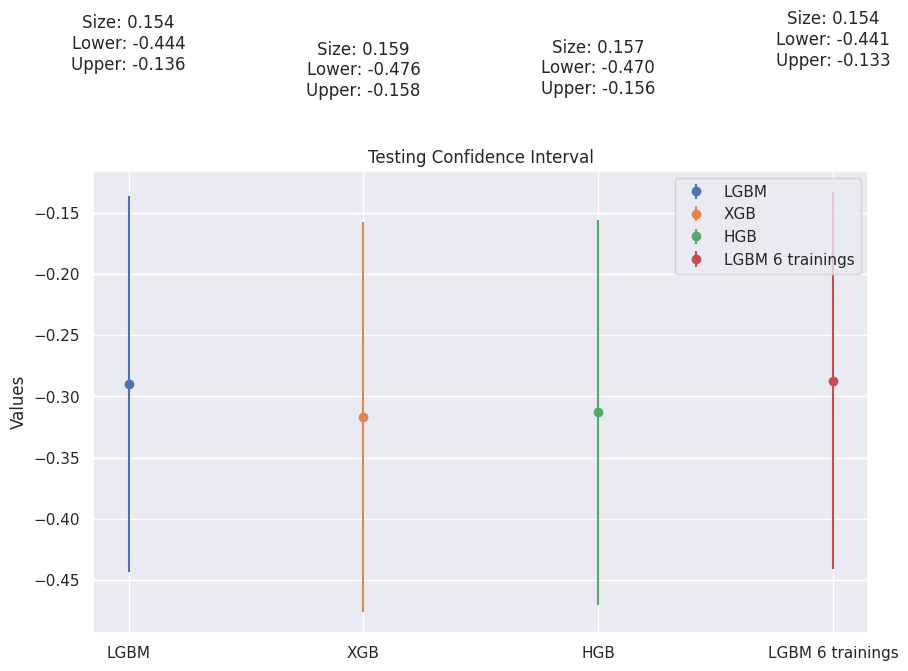

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels for each model
models = ['LGBM', 'XGB', 'HGB', 'LGBM 6 trainings']

# Confidence intervals for training and testing
Training_Confidence_Interval = [(lower_bound_data_LGBM, upper_bound_data_LGBM),
                                (lower_bound_data_XGB, upper_bound_data_XGB),
                                (lower_bound_data_HGB, upper_bound_data_HGB),
                                (lower_bound_data_LGBM_6trainings, upper_bound_data_LGBM_6trainings)]

Testing_Confidence_Interval = [(lower_bound_test_data_LGBM, upper_bound_test_data_LGBM),
                               (lower_bound_test_data_XGB, upper_bound_test_data_XGB),
                               (lower_bound_test_data_HGB, upper_bound_test_data_HGB),
                               (lower_bound_test_data_LGBM_6trainings, upper_bound_test_data_LGBM_6trainings)]

# Function to plot confidence intervals
def plot_confidence_interval(data, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(models))
    for i, (lower, upper) in enumerate(data):
        y = (lower + upper) / 2
        error = (upper - lower) / 2
        ax.errorbar(x[i], y, yerr=error, fmt='o', label=models[i])
        ax.text(x[i], y + error + 0.1, f'Size: {error:.3f}\nLower: {lower:.3f}\nUpper: {upper:.3f}', ha='center', va='bottom')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.legend()
    plt.show()

# Plotting confidence intervals for training
plot_confidence_interval(Training_Confidence_Interval, 'Training Confidence Interval')

# Plotting confidence intervals for testing
plot_confidence_interval(Testing_Confidence_Interval, 'Testing Confidence Interval')


Looking globally at the values obtained, we observe a certain trend in the performance of the different regressors for variance, predicted mean values and MSE, showing a better performance by LGBM, which is just slightly ahead of its version with improved parameters, followed by HGB and finally XGB, which has the worst values.

With regard to the values for the confidence interval, this maintains the same ranking of the repressors, but the difference appears negligible.
However, it should be noted that the mean error changes this ranking, placing LGBM 6 trainings in last place instead of second, with an error 2.5 times higher than its non-optimised version.

To conclude these analyses, we opted to keep the LGBM regressor for our solubility prediction, being the one presenting the best results for our data. We were somewhat surprised that its version with optimised parameters produced poorer values, the question being whether the database at our disposal was large enough to take maximum advantage of these regressors, the more qualitative and quantitative the data provided, the more accurate the predictions should be. To take this work further, it would be useful to see how the different regressors behave when faced with databases of different sizes and different precision, in order to study their dependency and see whether the regressors maintain their rankings or, on the contrary, change depending on the database.


#8. Saving of the trained model and standard scaler

As we mentioned previously, the LGBM regressor produced the best results, which is why we decided to use this model with the parameters we generated to create our package. To do that, we used the pickle library to save the model and the scaler in .pkl files to use them later.

In [ ]:
#Save the model and the scaler using pickel
import pickle
with open("model_LGBM.pkl","wb") as f:
    pickle.dump(model,f)

with open("scaler_LGBM.pkl","wb") as f:
    pickle.dump(custom_scaler,f)